# Check Electron populations
Use the implemented functions
- Compare secondary and Primary cases

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=True, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

In [11]:
clust.X_cre1_E

{'R_norm': <Quantity 1369.4682155 kpc>, 'X': 0.07}

In [12]:
clust.X_crp_E

{'R_norm': <Quantity 1369.4682155 kpc>, 'X': 0}

## Check Density and Spectrum

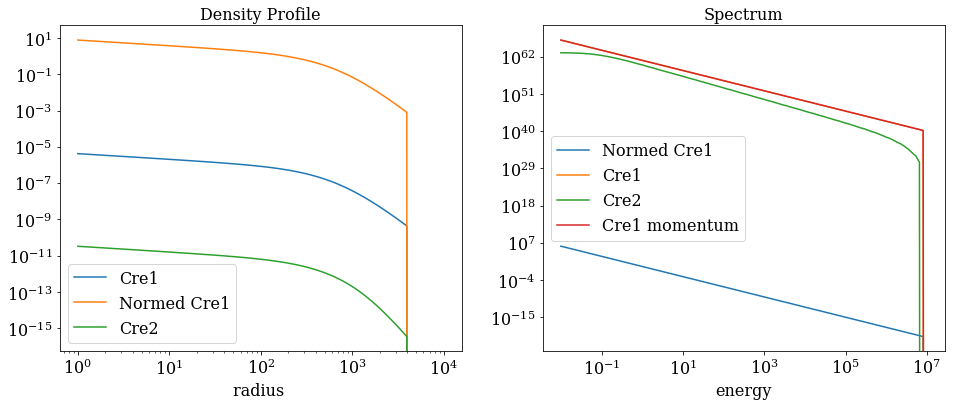

In [3]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a,b = clust.get_density_cre1_profile(radius)
plt.loglog(a,b, label='Cre1')
a, b = clust.get_normed_density_cre1_profile(radius)
plt.loglog(a, b, label='Normed Cre1')
a,b = clust.get_density_cre2_profile(radius)
plt.loglog(a,b, label='Cre2')
plt.xlabel('radius ')
plt.title("Density Profile")
plt.legend()


plt.subplot(122)
a, b = clust.get_normed_cre1_spectrum(energy)
plt.loglog(a, b,label = 'Normed Cre1')
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1')
a, b = clust.get_cre2_spectrum(energy)
plt.loglog(a,b, label = 'Cre2')
clust.spectrum_cre1_model["name"] = 'MomentumPowerLaw'
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1 momentum')
plt.xlabel('energy')
plt.title("Spectrum")
plt.legend()

## Check Synchrotron

In [4]:
clust.spectrum_cre1_model

{'Index': 3.0, 'PivotEnergy': <Quantity 1. TeV>, 'name': 'MomentumPowerLaw'}

Text(0.5,1,'Rate Total')

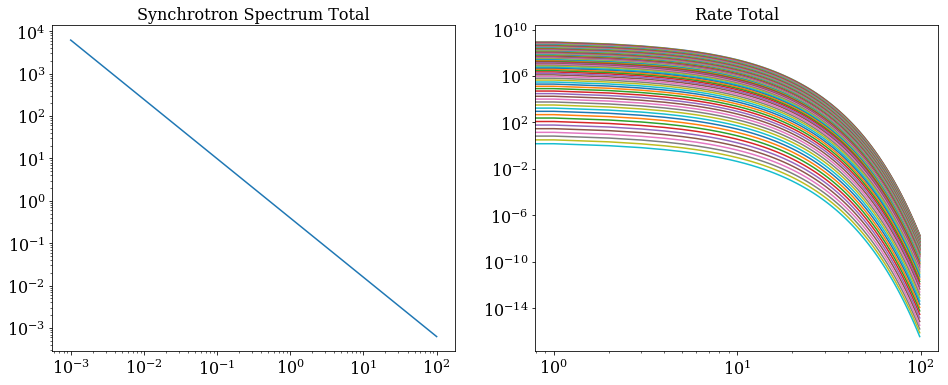

In [10]:

plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
clust.X_crp_E = {'X':0, 'R_norm': clust.R500}
clust.X_cre1_E = {'X':0.07, 'R_norm': clust.R500}
clust.spectrum_cre1_model["name"] = 'MomentumPowerLaw'

frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Synchrotron Spectrum Total")

#New one 
plt.subplot(122)
total_rate = clust.get_rate_synchrotron()
plt.loglog(total_rate)
plt.title("Rate Total")


# Fit to Coma Data
- Compare Secondary and Primary cases

In [6]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

from scipy import optimize

dat_freq = dat_freq.to('GHz')

The parameter suggests that we need 20 percent, more than the known value

In [7]:
%%time


## ASSUMING ALL EMISSION COMES FROM CRP GENERATED SECONDARY ELECTRONS
def syncfitSecondary(x,a, ind):
    clust.X_crp_E = {'X':a, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':0, 'R_norm': clust.R500}
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')

params2, params_covariance = optimize.curve_fit(syncfitSecondary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])


print "Secondary electron parameters: ",(params2)


Secondary electron parameters:  [0.0213517  3.01420068]
CPU times: user 2min 19s, sys: 50.8 ms, total: 2min 19s
Wall time: 2min 19s


## Primary Electrons
X suggests that we would need way too many primary electrons to be able to generate this much radio emission! 

In [9]:


def syncfitPrimary(x,a, ind):
    clust.X_crp_E = {'X':0.01, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


params1, params_covariance = optimize.curve_fit(syncfitPrimary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print "Primary Electron Parameters: ", (params1)

Primary Electron Parameters:  [0.0738352  3.79827979]


## Primary Electrons with Momentum Power Law

In [ ]:
def syncfitPrimarymom(x,a, ind):
    clust.X_crp_E = {'X':0, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'MomentumPowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


params3, params_covariance = optimize.curve_fit(syncfitPrimarymom, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print "Primary Electron Parameters: ", (params3)

## Plot Them all

In [ ]:
plt.figure(figsize=(15, 10))

## Plot Data
plt.errorbar(dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), yerr = dat_err.to_value('Jy') , 
             fmt="k.", label = "Coma Data")
## Plot Secondary Electron version
plt.loglog(dat_freq, syncfitSecondary(dat_freq.to_value('GHz'), params2[0],params2[1]),
         label='Secondary Electron Population Case')
## Plot Primary Electron version
plt.loglog(dat_freq, syncfitPrimary(dat_freq.to_value('GHz'), params1[0],params1[1]),
         label='Primary Electron Population Case')
## Plot Primary Electron version in momentum space
plt.loglog(dat_freq, syncfitPrimarymom(dat_freq.to_value('GHz'), params3[0],params3[1]),
         label='Primary Electron Population, Momentum')

plt.legend(loc='best')



## Least Square, primary electrons only

In [ ]:

import matplotlib.gridspec as gridspec

def syncfitPrim(p, x):
    clust.X_crp_E = {'X':p[0], 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':0, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'PowerLaw', 'Index':p[1] }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


def residual2(pr, x, y, dy):
    return (syncfitPrim(pr,x)-y)/dy

y = dat_flux.to_value('Jy')
x = dat_freq.to_value('GHz')
p02 = [ 0.01560813 , 3.81371339]
dy = dat_err.to_value('Jy')
pf2, cov2, info2, mesg2, success2 = optimize.leastsq(residual2, p02, args = (x, y, dy), full_output=1)
pf2_f, pf2_a = pf2
if success2 <= 4:
    print("Fit Converged")
    chisq2 = sum(info2["fvec"]*info2["fvec"])
    dof2 = len(x)-len(pf2)
    pferr2 = [np.sqrt(cov2[i,i]) for i in range(len(pf2))]
    diff = np.array(y - syncfitPrim(pf2, x))
    print("Converged with chi-squared ", chisq2)
    print("Number of degrees of freedom, dof =",dof2)
    print("Reduced chi-squared ", chisq2/dof2)
    print("Inital guess values:")
    print("  p0 =", p02)
    print("Best fit values:")
    print("  pf =", pf2)
    print("Uncertainties in the best fit values:")
    print("  pferr =", pferr2)
    print("residuals =", diff)
    print
    
    
    
    f, (ax1, ax2) = plt.subplots(nrows =2,sharex = True, figsize = (30,20),gridspec_kw={'height_ratios': [4,1]} )


    yerr = dy
    ax1.errorbar(x, y, yerr, fmt='k.', label = 'Data')
    #T = np.linspace(x.min(), x.max(), 2000)
    ax1.plot(x, syncfitPrim(pf2, x), 'r-', label = 'Fit')
    
   # ax1.loglog(T, fitfunc2(pf2, T), 'r-', label = 'Fit')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    ax1.set_title('Spectrum', fontsize = 30)
    ax1.set_xlabel('GHz', fontsize = 20)
    ax1.set_ylabel('Jy', fontsize = 20)
    ax1.tick_params(axis = 'both', which = "major", labelsize = 18)
    ax1.legend(fontsize = 20)
    
    
    
   # ax3 = fig2.add_subplot(gs[1])
    ax2.errorbar(x, diff, yerr = diff ,fmt="o")
    ax2.axhline(color="gray", zorder=-1)
    ax2.set_xlabel('GHz', fontsize = 20 )
    ax2.set_ylabel('residuals', fontsize = 20)
    ax2.tick_params(axis = 'both', which = "major", labelsize = 18)

    #ax2.set_ylim(-20, 20)
    #ax2.set_yticks((-20, 0, 20))
    

else:
    print('Fit did not converge')
    print(mesg2)


## LeastSq Secondary Electrons only 

In [ ]:

import matplotlib.gridspec as gridspec


def syncfitSec(p, x):
    clust.X_crp_E = {'X':p[0], 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':0, 'R_norm': clust.R500}
    clust.spectrum_cre1_model = {'name':'PowerLaw', 'Index':p[1] }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


def residual3(p, x, y, dy):
    return (syncfitSec(p,x)-y)/dy

y = dat_flux.to_value('Jy')
x = dat_freq.to_value('GHz')
p03 = [0.0213517,  3.01420068]
dy = dat_err.to_value('Jy')
pf3, cov3, info3, mesg3, success3 = optimize.leastsq(residual3, p03, args = (x, y, dy), full_output=1)
pf3_f, pf3_a = pf3
if success3 <= 4:
    print("Fit Converged")
    chisq3 = sum(info3["fvec"]*info3["fvec"])
    dof3 = len(x)-len(pf3)
    pferr3 = [np.sqrt(cov3[i,i]) for i in range(len(pf3))]
    diff = np.array(y - syncfitSec(pf3, x))
    print("Converged with chi-squared ", chisq3)
    print("Number of degrees of freedom, dof =",dof3)
    print("Reduced chi-squared ", chisq3/dof3)
    print("Inital guess values:")
    print("  p0 =", p03)
    print("Best fit values:")
    print("  pf =", pf3)
    print("Uncertainties in the best fit values:")
    print("  pferr =", pferr3)
    print("residuals =", diff)
    print
    
    
    
    f, (ax1, ax2) = plt.subplots(nrows =2,sharex = True, figsize = (30,20),gridspec_kw={'height_ratios': [4,1]} )


    yerr = dy
    ax1.errorbar(x, y, yerr, fmt='k.', label = 'Data')
    #T = np.linspace(x.min(), x.max(), 2000)
    ax1.plot(x, syncfitSec(pf3, x), 'r-', label = 'Fit')
    
   # ax1.loglog(T, fitfunc2(pf2, T), 'r-', label = 'Fit')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    ax1.set_title('Spectrum', fontsize = 30)
    ax1.set_xlabel('GHz', fontsize = 20)
    ax1.set_ylabel('Jy', fontsize = 20)
    ax1.tick_params(axis = 'both', which = "major", labelsize = 18)
    ax1.legend(fontsize = 20)
    
    
    
   # ax3 = fig2.add_subplot(gs[1])
    ax2.errorbar(x, diff, yerr = diff ,fmt="o")
    ax2.axhline(color="gray", zorder=-1)
    ax2.set_xlabel('GHz', fontsize = 20 )
    ax2.set_ylabel('residuals', fontsize = 20)
    ax2.tick_params(axis = 'both', which = "major", labelsize = 18)

    #ax2.set_ylim(-20, 20)
    #ax2.set_yticks((-20, 0, 20))
    

else:
    print('Fit did not converge')
    print(mesg3)
